# Learn

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install hyperopt lightgbm --user

import os
import numpy as np

import pandas as pd
import matplotlib.pylab as plt

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as units

from uncertainties import ufloat
from collections import Counter

from functions import *

%matplotlib inline

## Parameters

### Base name of matched catalogue
Name without file extension '.csv' of the matched catalogue containing magnitudes and spectra.

In [3]:
data_dir = f'{os.environ["HOME"]}/astro/data/CFIS/mb_cats/'

# Stephen's UNIONS+SDSS
#base_name = 'unions.ugriz'

# Stephen's UNIONS+DEEP3
#base_name = 'w3.ugriz.spec_matched'
base_name = 'w3.ugriz.spec'

# Stephen's UNIONS MK-matched with SDSS
#base_name = 'unions.ugriz2'

# Shear Data Club catalogue from Xavier, W3+Deep23 (2021)
#base_name = 'CFIS_matched_alldeep_catalog_lephare_RIZGY'

### Input file columns

#### Photometric bands

In [4]:
bands = ['u', 'g', 'r', 'i', 'z']

#bands = ['MAG_AUTO_Z', 'MAG_AUTO_Y', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_G,']

In [5]:
#### Spectroscopic redshift

col_zs = 'z_spec'

#col_zs = 'Z_SPEC'

### Survey name
Specify a name for the survey. Result files will be stored in a corresponding subdirectory.

In [6]:
survey = 'W3_Deep23'

#survey = 'Xavier_W3_Deep23'

### Machine-learning parameters

In [7]:
# Action on missing data:
# None, BEST, drop, mode, mean, median, int/float value 
#preprocessing = 'mode'
preprocessing = 'drop'

# number of samples for cross-validation, default=4
cv = 4

In [8]:
# Set paths

output_path = './'

# Input file path
path_to_csv = f'{data_dir}/{base_name}.csv'

# Output paths
output_name = 'out'

temp_path = 'temp/'

In [9]:
# Clean up and generate subdirectories
GenFiles = GenerateFiles(survey, bands, temp_path, output_name, output_path)
GenFiles.clean_temp_directories()
for f in [False, True]:
    GenFiles.make_directories(output=f)

Successfully removed the directory temp/W3_Deep23/d2d/ 
Successfully removed the directory temp/W3_Deep23/matched/ 
Successfully removed the directory temp/W3_Deep23/unmatched/ 
Successfully removed the directory temp/W3_Deep23/vignet/ 
Successfully removed the directory temp/W3_Deep23/redshift/ 
Successfully removed the directory temp/W3_Deep23/spectral_surveys/ 
Successfully created the directory temp/W3_Deep23/vignet/u 
Successfully created the directory temp/W3_Deep23/vignet/g 
Successfully created the directory temp/W3_Deep23/vignet/r 
Successfully created the directory temp/W3_Deep23/vignet/i 
Successfully created the directory temp/W3_Deep23/vignet/z 
Successfully created the directory temp/W3_Deep23/vignet/array 


In [10]:
# Set up ML class
ML = LearningAlgorithms(
    survey=survey,
    bands=bands,
    path_to_csv=path_to_csv,
    output_name=output_name,
    output_path=output_path,
    cv=cv,
    preprocessing=preprocessing,
    n_jobs=4
)

In [11]:
df_matched = pd.read_csv(path_to_csv)

In [12]:
df_matched

,RA,Dec,CFIS_ID,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,sg,z_spec,zero
0,214.521367,52.752021,2258286007117,21.542,0.029,-99.000,-99.000,20.404,0.008,20.412,0.007,20.467,0.011,2.265,0.2444,0.0
1,214.572297,52.750244,2258286007145,-99.000,-99.000,-99.000,-99.000,24.010,0.131,23.632,0.097,23.062,0.110,1.751,1.4011,0.0
2,214.442160,52.750625,2258286007149,-99.000,-99.000,24.991,0.055,24.491,0.146,23.951,0.132,23.948,0.178,1.206,0.6853,0.0
3,214.416452,52.751062,2258286007153,-99.000,-99.000,-99.000,-99.000,23.897,0.110,23.382,0.074,23.038,0.089,1.611,1.1246,0.0
4,214.470515,52.750971,2258286007155,-99.000,-99.000,-99.000,-99.000,24.098,0.143,-99.000,-99.000,-99.000,-99.000,1.668,0.6144,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13562,214.100574,52.202687,2264284029262,24.859,0.191,-99.000,-99.000,23.676,0.143,23.271,0.064,22.763,0.069,1.042,0.7590,0.0
13563,214.105256,52.242212,2264284029304,24.328,0.171,22.476,0.010,21.415,0.037,21.170,0.012,20.933,0.016,1.781,0.3658,0.0
13564,214.103080,52.240877,2264284029318,24.147,0.165,-99.000,-99.000,24.185,0.163,-99.000,-99.000,-99.000,-99.000,0.857,1.0298,0.0
13565,214.105374,52.246259,2264284029319,23.709,0.155,-99.000,-99.000,20.168,0.013,19.718,0.004,19.374,0.005,1.816,0.3660,0.0


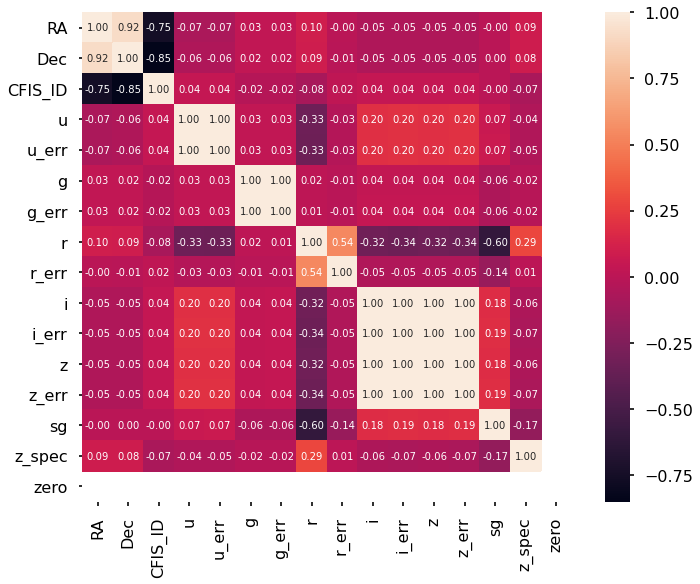

In [13]:
# Plot correlation matrix
ML.plot_corrmat(df_matched)

In [14]:
# Remove unwanted columns
cols_to_remove = []
for col in df_matched.columns:
    if (
        col not in bands
        and col != col_zs
    ):
        cols_to_remove.append(col)
df_matched.drop(columns=cols_to_remove, inplace=True)

In [15]:
n_cols = len(df_matched.columns)

# Move redshift column to the end if necessary
if not df_matched.columns[n_cols-1] == col_zs:
    zs = df_matched.pop(col_zs)
    df_matched.insert(n_cols-1, col_zs, zs)

In [18]:
# Remove missing data by hand (also done in processing later)
for col in df_matched.columns:
    print(col)
    df_matched.loc[df_matched[col] == -99, col] = np.nan

u
g
r
i
z
z_spec


In [19]:
len(df_matched)

13567

In [21]:
df_matched

,u,g,r,i,z,z_spec
0,21.542,NaN,20.404,20.412,20.467,0.2444
1,NaN,NaN,24.010,23.632,23.062,1.4011
2,NaN,24.991,24.491,23.951,23.948,0.6853
3,NaN,NaN,23.897,23.382,23.038,1.1246
4,NaN,NaN,24.098,NaN,NaN,0.6144
...,...,...,...,...,...,...
13562,24.859,NaN,23.676,23.271,22.763,0.7590
13563,24.328,22.476,21.415,21.170,20.933,0.3658
13564,24.147,NaN,24.185,NaN,NaN,1.0298
13565,23.709,NaN,20.168,19.718,19.374,0.3660


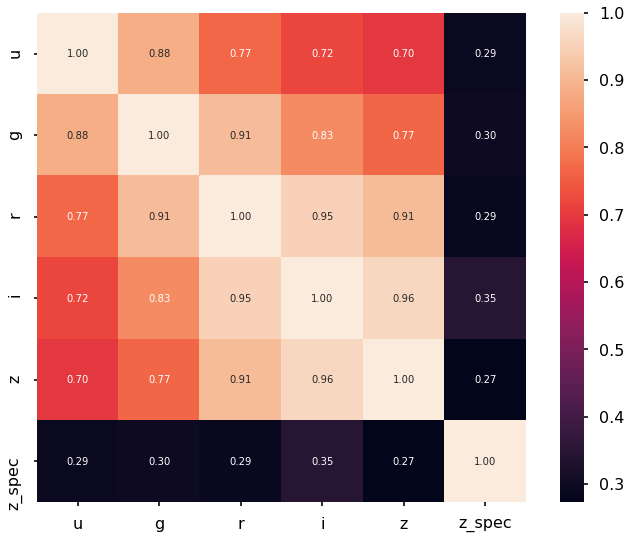

In [22]:
# Plot correlation matrix of preprocessed data
ML.plot_corrmat(df_matched)

In [23]:
# Set up ML algorithms

algs = {
    'RF' : RandomForest,
    'SVR' : SupportVectorRegression,
    'LGB' : LightGBM,
    'XGB' : XGBoost,
    'GBR' : GradientBoostingRegression,
    'KRR' : KernelRidgeRegression,
}

# Not working:
#     'CNN' : ConvolutionalNeuralNetwork,
#     'RF_OPT' : RandomForestOptimizer, 
#     'ENET' : ElasticNetRegression,
#    'LASSO' : LassoRegression,

# needs tensorflow
#     'ANN' : ArtificialNeuralNetwork,

In [24]:
weights = None
method = {}

for alg_name in algs:
    print(alg_name)
    best_score = 1
    alg = algs[alg_name]
    method[alg_name] = alg(
        survey=survey,
        bands=bands,
        output_name=output_name,
        temp_path=temp_path,
        dataframe=df_matched,
        path_to_csv=None,
        validation_set=False,
        output_path=output_path,
        sample_weight=weights,
        cv=cv,
        preprocessing=preprocessing,
        n_jobs=1
    )

RF
SVR
LGB
XGB
GBR
KRR


In [28]:
# Run ML algorithms
score = {}
predict = {}
y_pred_dict = {}
y_test_dict = {}

for alg_name in algs:

    print(alg_name)
    
    # Get score from cross-validation
    score[alg_name] = method[alg_name].score(df_matched)

    # Fit model
    regressor, y_pred, y_test = method[alg_name].model()

    # Get predicted model values
    y_pred_dict[alg_name] = y_pred

    # Get ground truth for test
    y_test_dict[alg_name] = y_test
    
    # Get function to create prediction on any input
    predict[alg_name] = regressor.predict

  0%|          | 0/4 [00:00<?, ?it/s]

RF


  0%|          | 0/4 [00:00<?, ?it/s]

SVR


  0%|          | 0/4 [00:00<?, ?it/s]

LGB


  0%|          | 0/4 [00:00<?, ?it/s]

XGB


  0%|          | 0/4 [00:00<?, ?it/s]

GBR


  0%|          | 0/4 [00:00<?, ?it/s]

KRR


100%|██████████| 4/4 [00:34<00:00,  8.70s/it]


In [29]:
# Print sigma and eta with error bars, as computed from cross-validation
for alg_name in algs:
    print(alg_name)
    sigma = ufloat(score[alg_name][0], score[alg_name][1])
    eta = ufloat(score[alg_name][2], score[alg_name][3])
    print(
        f'{alg_name:5s}: sigma={sigma:.3gP}, '
        + f'eta={eta:.3gP}'
    )

RF
RF   : sigma=0.205±0.002, eta=0.466±0.005
SVR
SVR  : sigma=0.197±0.003, eta=0.455±0.004
LGB
LGB  : sigma=0.200±0.001, eta=0.456±0.000
XGB
XGB  : sigma=0.217±0.002, eta=0.491±0.003
GBR
GBR  : sigma=0.210±0.002, eta=0.474±0.002
KRR
KRR  : sigma=0.202±0.002, eta=0.460±0.003


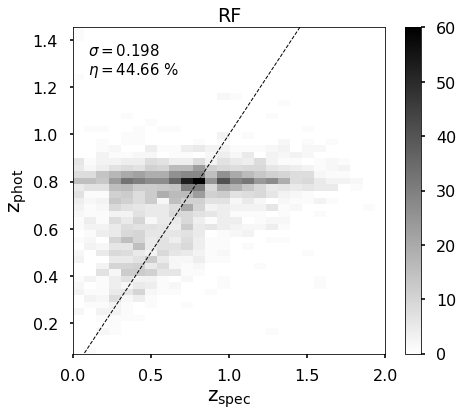

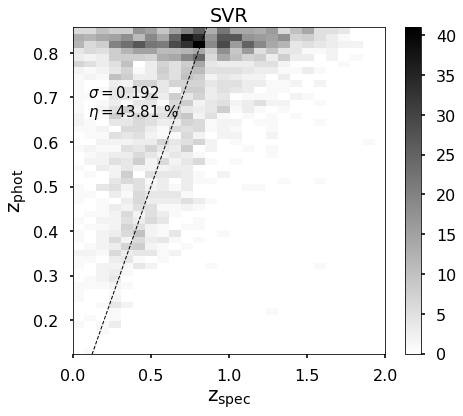

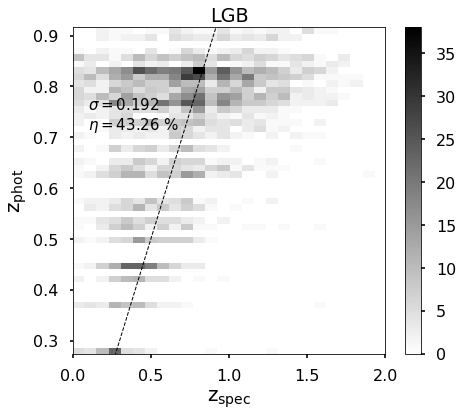

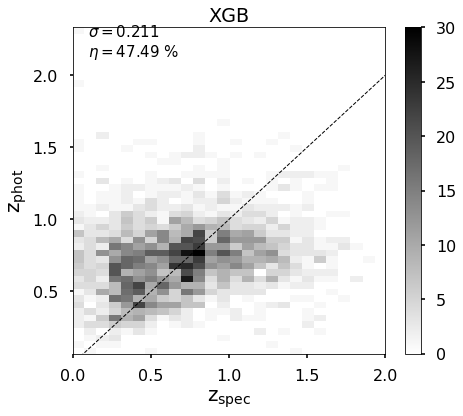

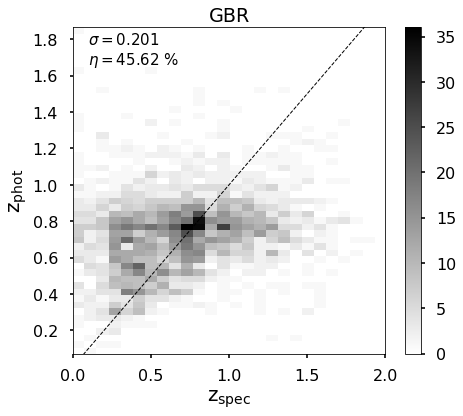

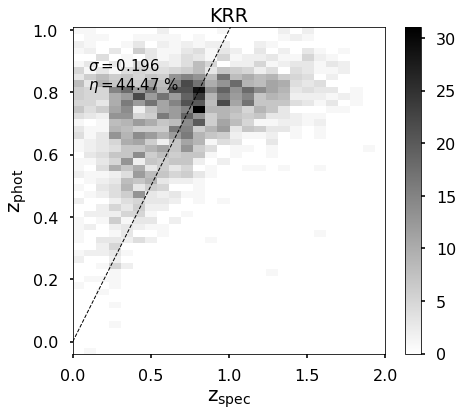

In [61]:
# Plot
lim = 2
for alg_name in algs:
    method[alg_name].plot_zphot_zspec(y_pred_dict[alg_name], y_test_dict[alg_name], alg_name, lim)

0.08653076268850718 0.13618677042801555


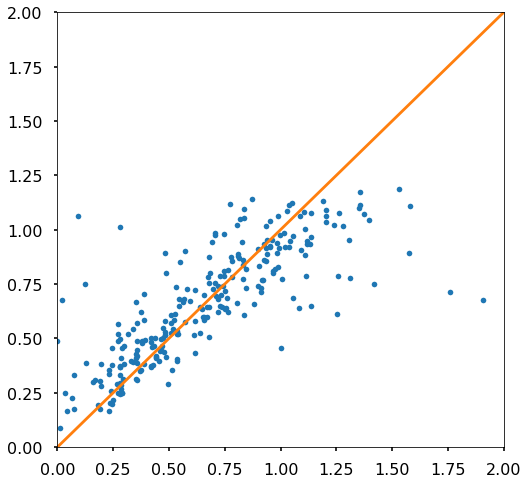

In [92]:
# Test of the predict function

plt.figure(figsize=(8, 8))
yphot = predict['RF'](method['RF'].X_test)
yspec = np.array(method['RF'].y_test)
plt.plot(yspec, yphot, '.')
plt.plot([0, 2], [0, 2], '-')
plt.xlim(0, 2)
_ = plt.ylim(0, 2)

sigma, eta = method['RF'].sigma_eta_score(yphot, yspec)
print(sigma, eta)

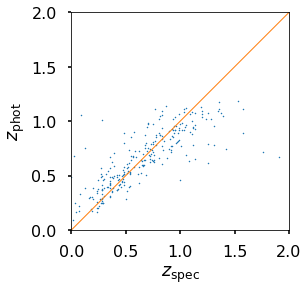

In [93]:
fig, (ax) = plt.subplots(1, 1)

ax.plot(y_test_dict['RF'], y_pred_dict['RF'], '.', markersize=3)
ax.plot([0, lim], [0, lim], '-', linewidth=1)
ax.set_ylim(0, lim)
ax.set_xlim(0, lim)
ax.set_xlabel(r'$z_{\rm spec}$')
ax.set_ylabel(r'$z_{\rm phot}$')
ax.set_aspect('equal')
_ = plt.savefig(f'{output_path}/output/{survey}/{output_name}/figures/out_RF_zphot_zspec_2.pdf')

# Apply

## Open SP catalogue

In [56]:
base_name_ph = 'cfis_800d2_SP_v1.0'

In [57]:
hdu = fits.open(f'{base_name_ph}.fits', memmap=False)

In [58]:
data = hdu[1].data

In [59]:
# Print column names
print(data.dtype.names)

('RA', 'Dec', 'e1', 'e2', 'w', 'mag', 'snr', 'e1_uncal', 'e2_uncal', 'R_g11', 'R_g22', 'R_g12', 'R_g21', 'CFIS_ID', 'distance', 'e1_PSF', 'e2_PSF', 'fwhm_PSF', 'CFIS_ID_mb', 'CFIS_U_MAG_AUTO', 'CFIS_U_MAGERR_AUTO', 'HSC_G_MAG_AUTO', 'HSC_G_MAGERR_AUTO', 'CFIS_R_MAG_AUTO', 'CFIS_R_MAGERR_AUTO', 'PS_i_stk_kron', 'PS_i_stk_kron_err', 'PS_z_stk_kron', 'PS_z_stk_kron_err', 'CFIS_R_StarGal')


## Create data frame band column names defined above

In [60]:
# Column names corresponding to the above-defined bands
cols = ['CFIS_U_MAG_AUTO', 'HSC_G_MAG_AUTO', 'CFIS_R_MAG_AUTO', 'PS_i_stk_kron', 'PS_z_stk_kron']

In [61]:
data_for_df = {}
for b, c in zip(bands, cols):
    print(b, c)
    data_for_df[b] = data[c].tolist()

u CFIS_U_MAG_AUTO
g HSC_G_MAG_AUTO
r CFIS_R_MAG_AUTO
i PS_i_stk_kron
z PS_z_stk_kron


In [62]:
df = pd.DataFrame(data=data_for_df)

## Deal with missing data

In [63]:
# Replace invalid magnitudes with nan
df = df.replace([-99, -999], np.nan)

In [64]:
def missing_data(dataset):
    all_data_na = (dataset.isnull().sum() / len(dataset)) * 100
    all_data_na = all_data_na.drop(
        all_data_na[all_data_na == 0].index
    ).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
    
    return missing_data 

In [65]:
missing = missing_data(df)

In [100]:
# missing data
if type(preprocessing) == float:
    for i in missing.index:
        df[i] = df[i].fillna(preprocessing)
else:
    if preprocessing == 'mode':
        for i in missing.index:
            df[i] = df[i].fillna(df[i].mode()[0])
    elif preprocessing == 'drop':
        df.dropna()

In [101]:
print(preprocessing, len(df))

26.0 8338365


In [100]:
yphot = predict['RF'](df)

0.811151581239937 0.6656307392996108


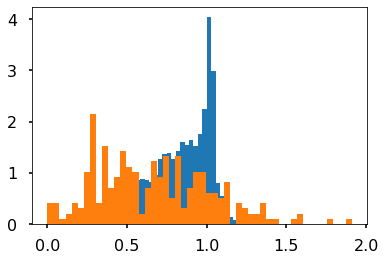

In [101]:
_ = plt.hist(yphot, bins=50, density=True)
_ = plt.hist(yspec, bins=50, density=True)
print(np.mean(yphot), np.mean(yspec))

In [46]:
col_names_out = ['ra', 'dec', 'g1', 'g2', 'w', 'mag', 'snr', 'CFIS_ID',
                 'CFIS_U_MAG_AUTO', 'CFIS_U_MAGERR_AUTO',
                 'HSC_G_MAG_AUTO', 'HSC_G_MAGERR_AUTO',
                 'CFIS_R_MAG_AUTO', 'CFIS_R_MAGERR_AUTO',
                 'PS_i_stk_kron', 'PS_i_stk_kron_err',
                 'PS_z_stk_kron', 'PS_z_stk_kron_err']

In [47]:
cols_orig = []
for col_input in data.columns:
    if col_input.name in col_names_out:
        cols_orig.append(col_input)
cols_orig = fits.ColDefs(cols_orig)

In [48]:
col_new = fits.ColDefs(
    [
        fits.Column(name='z_phot', format='D', array=yphot)
    ]
)

In [49]:
hdu_out = fits.BinTableHDU.from_columns(cols_orig + col_new)

In [51]:
out_name = f'{base_name_ph}_zp_{survey}_v0.2.fits'
hdu_out.writeto(out_name)